In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install --upgrade transformers
!pip install tensorflow-io
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 57.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling

In [3]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.16.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtype

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import torch
import tensorflow as tf
import keras
from tensorflow.python.keras import activations, optimizers, losses
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, roc_auc_score
import transformers
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [5]:
print(transformers.__version__) # make sure the version is 4.39, else optimizer would have error

4.39.3


In [6]:
def load_data(filepath):
  data = pd.read_csv(filepath)
  print(data.head())

  return data

In [7]:
data = load_data("/content/drive/MyDrive/MDS_FYP/Data/cleaned_data.csv")

                                                text  label
0  ['ex', 'wife', 'threaten', 'suiciderec', 'left...      1
1  ['weird', 'dont', 'get', 'affect', 'compliment...      0
2  ['final', 'almost', 'never', 'hear', 'bad', 'y...      0
3  ['need', 'helpjust', 'help', 'im', 'cri', 'hard']      1
4  ['im', 'losthello', 'name', 'adam', 'ive', 'st...      1


In [8]:
# separate training and holdout set
training_data, holdout_data = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
def plot_scores_across_folds(scores_list, eval_metrics, output_file=None):
    num = len(scores_list)
    plt.plot(scores_list, marker="o", label=eval_metrics)
    plt.xlabel("Fold")
    plt.ylabel(f"{eval_metrics}")
    plt.title(f"{eval_metrics} across Folds")
    plt.legend()
    plt.xticks(range(0, num), [str(i+1) for i in range(num)])
    plt.show()

    if output_file:
        plt.savefig(output_file)

In [10]:
def pred_performance_measure(model, val_dataset, labels_val):
    # perform prediction on the validation dataset
    predictions = model.predict(val_dataset)
    predicted_probs = predictions[0][:, 0] # use the first output and raw logits directly
    predicted_labels = (predicted_probs >= 0.5).astype(int) # convert probability into binary labels

    # create confusion matrix
    confusion_matrix_data = tf.math.confusion_matrix(labels_val, predicted_labels)
    plt.figure(figsize=(5,3))
    sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix")
    plt.show()

    # calculate row sums (actual label counts) and column sums (predicted label counts)
    row_cnt = confusion_matrix_data.numpy().sum(axis=1)
    col_cnt = confusion_matrix_data.numpy().sum(axis=0)
    confusion_matrix_perc = (confusion_matrix_data/row_cnt[:, np.newaxis])*100
    plt.figure(figsize=(5,3))
    sns.heatmap(confusion_matrix_perc, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix (%)")
    plt.show()

    accuracy = accuracy_score(labels_val, predicted_labels)
    precision = precision_score(labels_val, predicted_labels)
    recall = recall_score(labels_val, predicted_labels)
    f1 = f1_score(labels_val, predicted_labels)
    roc_auc = roc_auc_score(labels_val, predicted_probs)

    # create and display ROC AUC plot
    fpr, tpr, _ = roc_curve(labels_val, predicted_probs)
    plt.figure(figsize=(5,3))
    plt.plot(fpr, tpr, label="ROC Curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    return accuracy, precision, recall, f1, roc_auc

In [11]:
def calc_avg_cv(accuracy_scores_list, precision_scores_list, recall_scores_list, f1_scores_list, roc_auc_values, n_folds):
    """
    calculate the average value after n-fold of cross validation
    """
    final_accuracy = sum(accuracy_scores_list) / n_folds
    final_precision = sum(precision_scores_list) / n_folds
    final_recall = sum(recall_scores_list) / n_folds
    final_f1 = sum(f1_scores_list) / n_folds
    final_roc_auc = sum(roc_auc_values) / n_folds

    return final_accuracy, final_precision, final_recall, final_f1, final_roc_auc

In [12]:
def holdout_performance_measure(model, tokenizer, holdout_set):
    encodings = {
        "input_ids_holdout": [],
        "attention_masks_holdout": []
    }

    for text_row in holdout_set["text"]:
        text_str = " ".join(text_row)
        tokens = tokenizer(text_row, truncation=True, padding="max_length", max_length=64, return_tensors="tf")
        encodings["input_ids_holdout"].append(tokens["input_ids"])
        encodings["attention_masks_holdout"].append(tokens["attention_mask"])

    input_ids_holdout = np.array(encodings["input_ids_holdout"])
    attention_masks_holdout = np.array(encodings["attention_masks_holdout"])
    input_ids_holdout = np.squeeze(input_ids_holdout, axis=1)
    attention_masks_holdout = np.squeeze(attention_masks_holdout, axis=1)

    holdout_labels = np.array(holdout_data["label"])

    holdout_predictions = model.predict([input_ids_holdout, attention_masks_holdout])
    holdout_proba = holdout_predictions.logits[:, 0]
    holdout_probabilities = tf.nn.sigmoid(holdout_proba).numpy()
    holdout_predictions_class = (holdout_proba > 0.5).astype(int)

    accuracy_holdout = accuracy_score(holdout_labels, holdout_predictions_class)
    precision_holdout = precision_score(holdout_labels, holdout_predictions_class)
    recall_holdout = recall_score(holdout_labels, holdout_predictions_class)
    f1_holdout = f1_score(holdout_labels, holdout_predictions_class)
    roc_auc_holdout = roc_auc_score(holdout_labels, holdout_probabilities)

    return accuracy_holdout, precision_holdout, recall_holdout, f1_holdout, roc_auc_holdout

In [13]:
def save_result_to_csv(accuracy, precision, recall, f1_score, roc_auc, csv_filepath):
    if os.path.exists(csv_filepath):
        existing_df = pd.read_csv(csv_filepath)
    else:
        existing_df = pd.DataFrame()

    new_row = pd.DataFrame({
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1_Score": [f1_score],
        "ROC AUC": [roc_auc]
    })

    existing_df = pd.concat([existing_df, new_row], ignore_index=True)
    existing_df.to_csv(csv_filepath, index=False)

    return existing_df

# DistilBERT

In [14]:
BATCH_SIZE = 16
N_FOLDS = 5
N_EPOCHS = 4
LEARNING_RATE = 2e-5
input_ids = []
attention_masks = []

labels = np.array(training_data["label"])

MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
encodings = {
    "input_ids": [],
    "attention_mask": []
}

for text_row in training_data["text"]:
    text_str = " ".join(text_row)
    tokens = tokenizer(text_row, truncation=True, padding="max_length", max_length=64, return_tensors="tf")
    input_ids.append(tokens["input_ids"])
    attention_masks.append(tokens["attention_mask"])

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)
print("Labels shape:", labels.shape)

Input IDs shape: (185659, 1, 64)
Attention Masks shape: (185659, 1, 64)
Labels shape: (185659,)


In [16]:
input_ids = np.squeeze(input_ids, axis=1)
attention_masks = np.squeeze(attention_masks, axis=1)
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)
print("Labels shape:", labels.shape)

Input IDs shape: (185659, 64)
Attention Masks shape: (185659, 64)
Labels shape: (185659,)


In [17]:
training_accuracies = []
training_losses = []
val_accuracies = []
val_losses = []
accuracy_scores_list = []
precision_scores_list = []
recall_scores_list = []
f1_scores_list = []
roc_auc_values = []

input_data = np.array(list(zip(input_ids, attention_masks, labels)), dtype=object)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Fold 1/5
Epoch 1/4


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9283/9283 [==============================] - 561s 56ms/step - loss: 0.1410 - accuracy: 0.9437 - val_loss: 0.1148 - val_accuracy: 0.9596
Epoch 2/4
9283/9283 [==============================] - 504s 54ms/step - loss: 0.0854 - accuracy: 0.9668 - val_loss: 0.1146 - val_accuracy: 0.9535
Epoch 3/4
9283/9283 [==============================] - 502s 54ms/step - loss: 0.0580 - accuracy: 0.9780 - val_loss: 0.1052 - val_accuracy: 0.9632
Epoch 4/4
9283/9283 [==============================] - 507s 55ms/step - loss: 0.0396 - accuracy: 0.9849 - val_loss: 0.1506 - val_accuracy: 0.9609


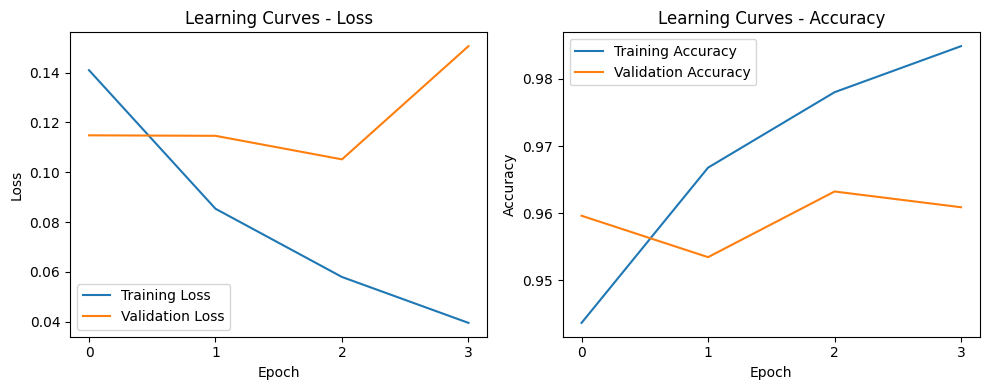

2321/2321 [==============================] - 49s 20ms/step


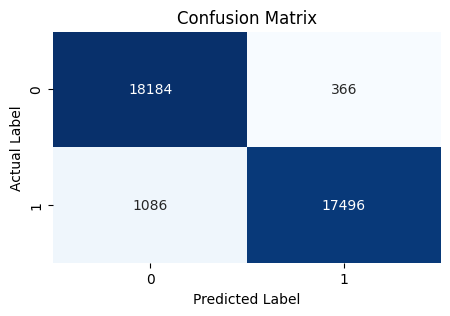

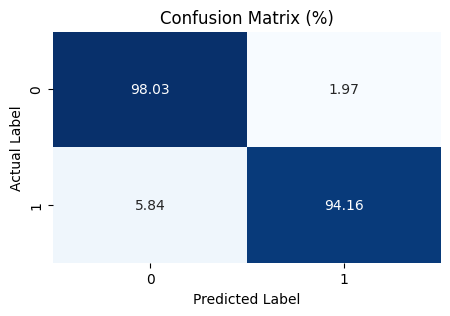

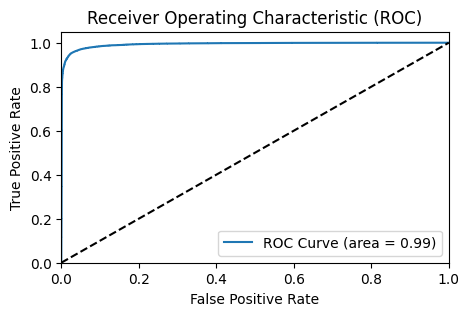

Fold 2/5
Epoch 1/4
9283/9283 [==============================] - 508s 55ms/step - loss: 0.0509 - accuracy: 0.9823 - val_loss: 0.0290 - val_accuracy: 0.9890
Epoch 2/4
9283/9283 [==============================] - 507s 55ms/step - loss: 0.0305 - accuracy: 0.9894 - val_loss: 0.0288 - val_accuracy: 0.9894
Epoch 3/4
9283/9283 [==============================] - 505s 54ms/step - loss: 0.0196 - accuracy: 0.9933 - val_loss: 0.0370 - val_accuracy: 0.9866
Epoch 4/4
9283/9283 [==============================] - 508s 55ms/step - loss: 0.0149 - accuracy: 0.9949 - val_loss: 0.0410 - val_accuracy: 0.9871


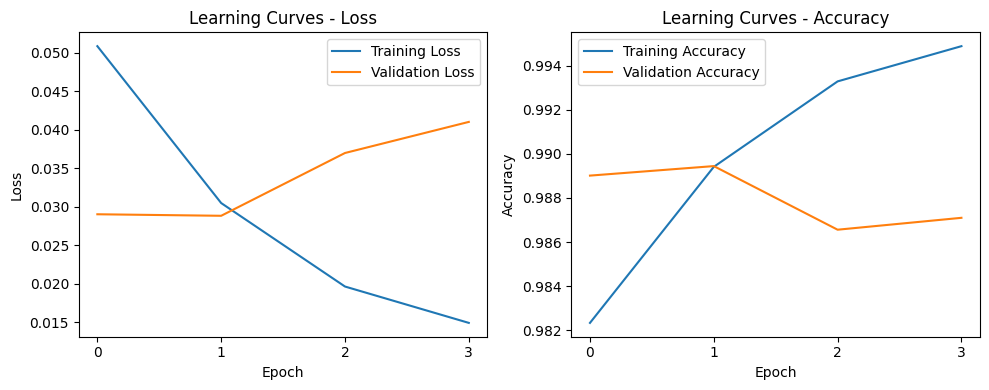

2321/2321 [==============================] - 45s 19ms/step


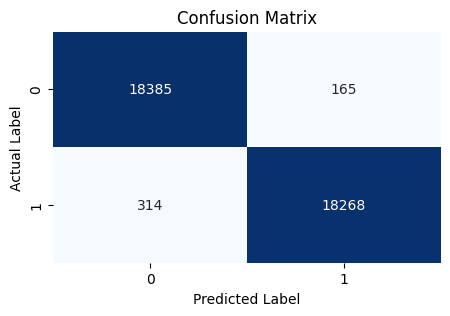

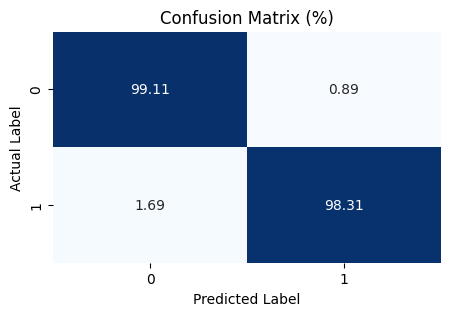

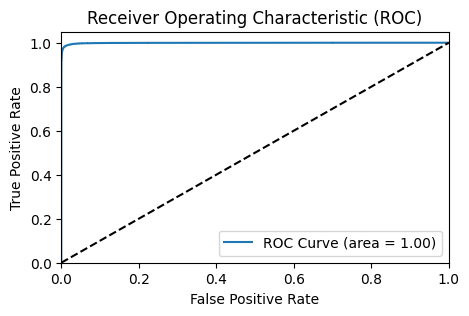

Fold 3/5
Epoch 1/4
9283/9283 [==============================] - 514s 55ms/step - loss: 0.0221 - accuracy: 0.9927 - val_loss: 0.0089 - val_accuracy: 0.9974
Epoch 2/4
9283/9283 [==============================] - 518s 56ms/step - loss: 0.0135 - accuracy: 0.9953 - val_loss: 0.0085 - val_accuracy: 0.9969
Epoch 3/4
9283/9283 [==============================] - 504s 54ms/step - loss: 0.0105 - accuracy: 0.9963 - val_loss: 0.0112 - val_accuracy: 0.9961
Epoch 4/4
9283/9283 [==============================] - 503s 54ms/step - loss: 0.0091 - accuracy: 0.9968 - val_loss: 0.0183 - val_accuracy: 0.9942


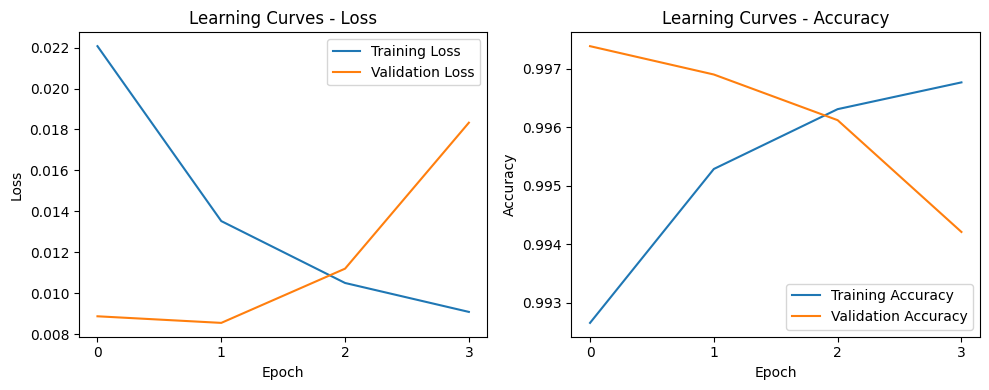

2321/2321 [==============================] - 45s 19ms/step


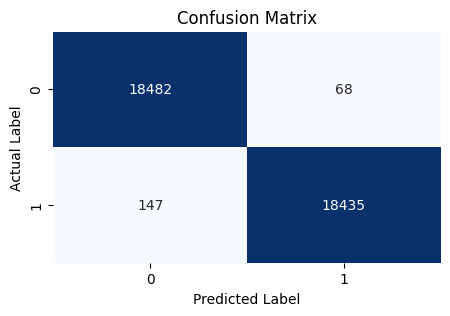

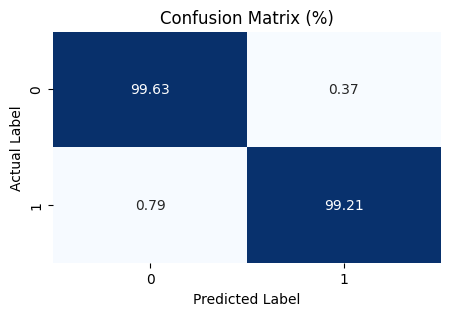

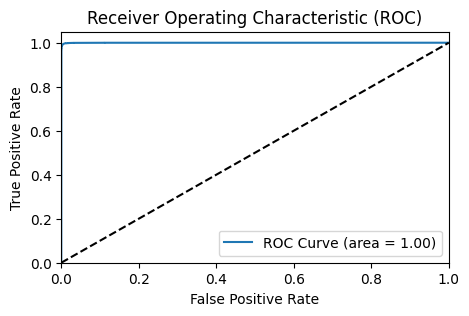

Fold 4/5
Epoch 1/4
9283/9283 [==============================] - 507s 55ms/step - loss: 0.0122 - accuracy: 0.9958 - val_loss: 0.0037 - val_accuracy: 0.9988
Epoch 2/4
9283/9283 [==============================] - 507s 55ms/step - loss: 0.0088 - accuracy: 0.9968 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 3/4
9283/9283 [==============================] - 509s 55ms/step - loss: 0.0074 - accuracy: 0.9973 - val_loss: 0.0053 - val_accuracy: 0.9981
Epoch 4/4
9283/9283 [==============================] - 506s 54ms/step - loss: 0.0065 - accuracy: 0.9978 - val_loss: 0.0061 - val_accuracy: 0.9978


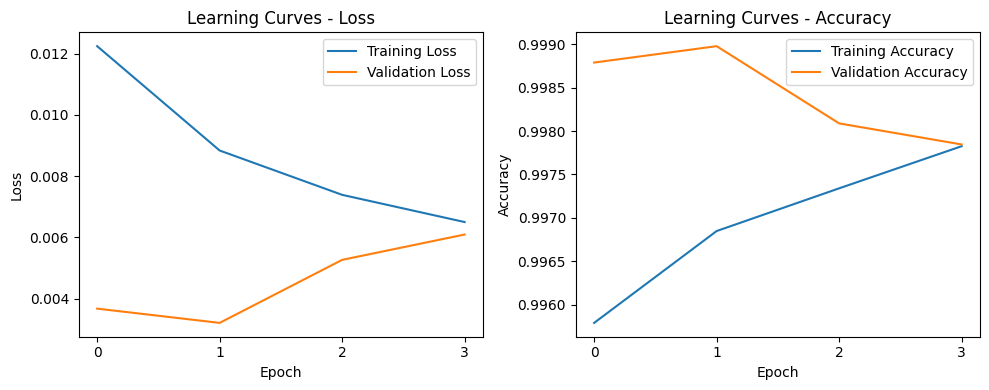

2321/2321 [==============================] - 45s 20ms/step


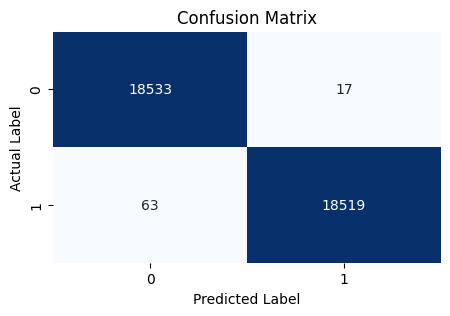

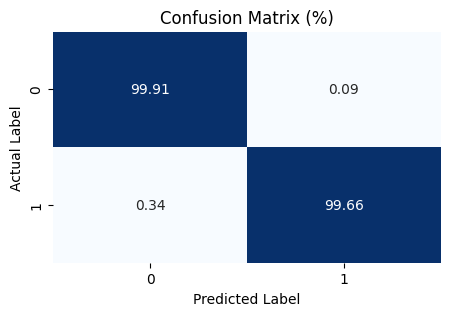

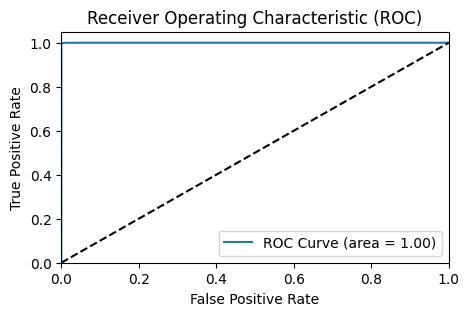

Fold 5/5
Epoch 1/4
9283/9283 [==============================] - 506s 54ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 0.0022 - val_accuracy: 0.9993
Epoch 2/4
9283/9283 [==============================] - 509s 55ms/step - loss: 0.0067 - accuracy: 0.9977 - val_loss: 0.0049 - val_accuracy: 0.9980
Epoch 3/4
9283/9283 [==============================] - 513s 55ms/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.0059 - val_accuracy: 0.9977
Epoch 4/4
9283/9283 [==============================] - 526s 57ms/step - loss: 0.0056 - accuracy: 0.9980 - val_loss: 0.0049 - val_accuracy: 0.9983


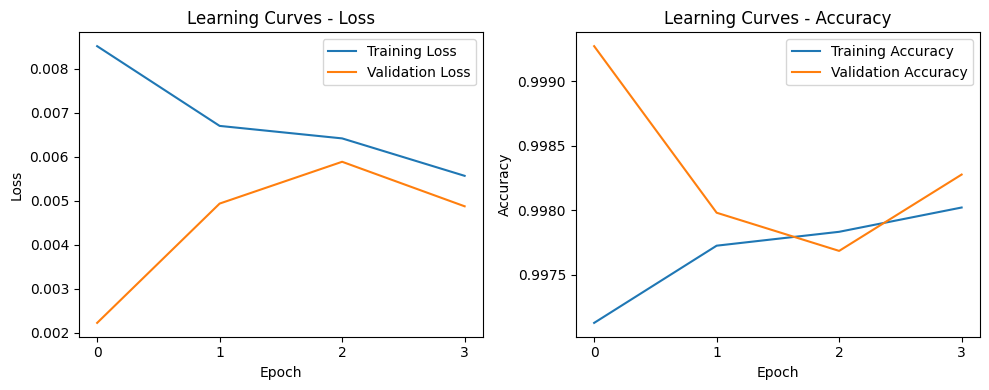

2321/2321 [==============================] - 45s 19ms/step


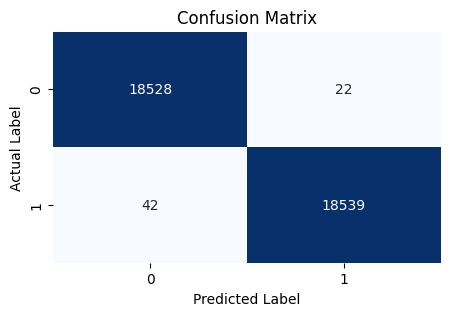

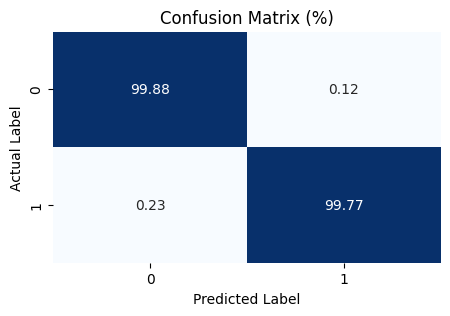

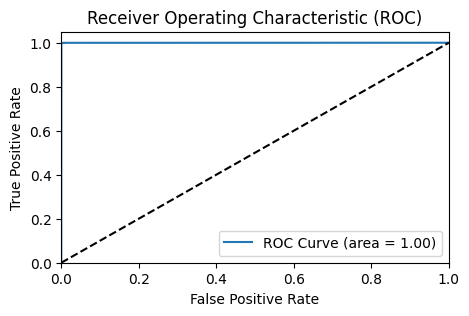

Total Training Time:  10524.33 seconds


In [18]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1) # binary classifcation
model.layers[-1].activation = tf.keras.activations.sigmoid # add sigmoid activation to the output layer
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True) # model outputs logits instead of probabilities
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

start_time = time.time()

# split data based on stratification of labels
for fold, (train_index, test_index) in enumerate(kfold.split(input_data, labels)):
    print(f"Fold {fold + 1}/{N_FOLDS}")

    # Split the data into train and validation sets for this fold
    input_train_fold, input_test_fold = input_data[train_index], input_data[test_index]
    input_ids_train_fold, attention_masks_train_fold, labels_train_fold = zip(*input_train_fold)
    input_ids_test_fold, attention_masks_test_fold, labels_test_fold = zip(*input_test_fold)

    # Convert the input data and labels to numpy arrays
    input_ids_train_fold = np.array(input_ids_train_fold)
    attention_masks_train_fold = np.array(attention_masks_train_fold)
    labels_train_fold = np.array(labels_train_fold)

    input_ids_test_fold = np.array(input_ids_test_fold)
    attention_masks_test_fold = np.array(attention_masks_test_fold)
    labels_test_fold = np.array(labels_test_fold)

    train_input_dataset_fold = tf.data.Dataset.from_tensor_slices((input_ids_train_fold, attention_masks_train_fold))
    train_label_dataset_fold = tf.data.Dataset.from_tensor_slices(labels_train_fold)
    train_dataset_fold = tf.data.Dataset.zip((train_input_dataset_fold, train_label_dataset_fold))

    test_input_dataset_fold = tf.data.Dataset.from_tensor_slices((input_ids_test_fold, attention_masks_test_fold))
    test_label_dataset_fold = tf.data.Dataset.from_tensor_slices(labels_test_fold)
    test_dataset_fold = tf.data.Dataset.zip((test_input_dataset_fold, test_label_dataset_fold))

    # Shuffle the training dataset
    train_dataset_fold = train_dataset_fold.shuffle(buffer_size=len(input_ids_train_fold))

    # Batch and prefetch the datasets separately
    train_dataset_fold = train_dataset_fold.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset_fold = test_dataset_fold.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    history = model.fit(train_dataset_fold, validation_data=test_dataset_fold, epochs=N_EPOCHS)

    # plot learning curves for this fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves - Loss')
    plt.xticks(range(0, N_EPOCHS))
    plt.legend()

    # plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves - Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.xticks(range(0, N_EPOCHS))
    plt.show()

    training_accuracies.append(history.history['accuracy'])
    training_losses.append(history.history['loss'])
    val_accuracies.append(history.history['val_accuracy'])
    val_losses.append(history.history['val_loss'])

    (accuracy_val, precision_val, recall_val, f1_val, roc_auc_fold) = pred_performance_measure(model, test_dataset_fold, labels_test_fold)

    accuracy_scores_list.append(accuracy_val)
    precision_scores_list.append(precision_val)
    recall_scores_list.append(recall_val)
    f1_scores_list.append(f1_val)
    roc_auc_values.append(roc_auc_fold)

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time: .2f} seconds")

In [19]:
CSV_FILE_PATH = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_metric_results_distilbert.csv"

if os.path.exists(CSV_FILE_PATH):
    training_df = pd.read_csv(CSV_FILE_PATH)
else:
    training_df = pd.DataFrame()

new_row = pd.DataFrame({
    "Training Accuracy": training_accuracies,
    "Training Loss": training_losses,
    "Validation Accuracy": accuracy_scores_list,
    "Validation Loss": val_losses,
    "Precision": precision_scores_list,
    "Recall": recall_scores_list,
    "F1_Score": f1_scores_list,
    "ROC AUC": roc_auc_values
})

training_df = pd.concat([training_df, new_row], ignore_index=True)
training_df.to_csv(CSV_FILE_PATH, index=False)

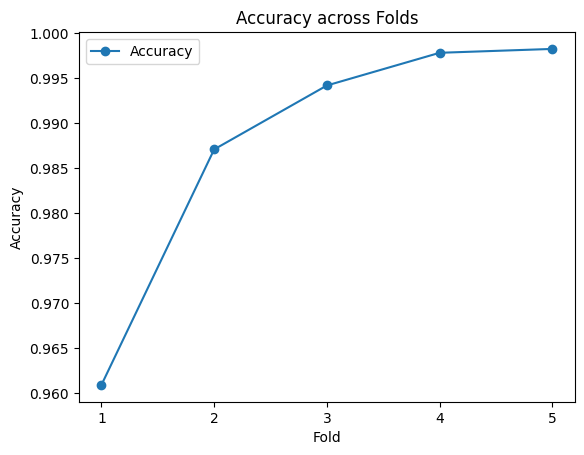

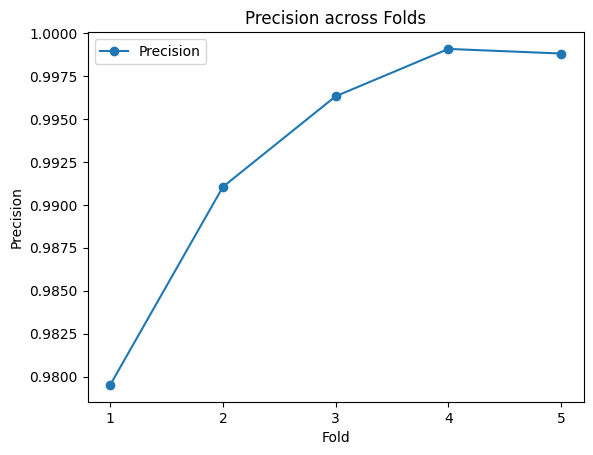

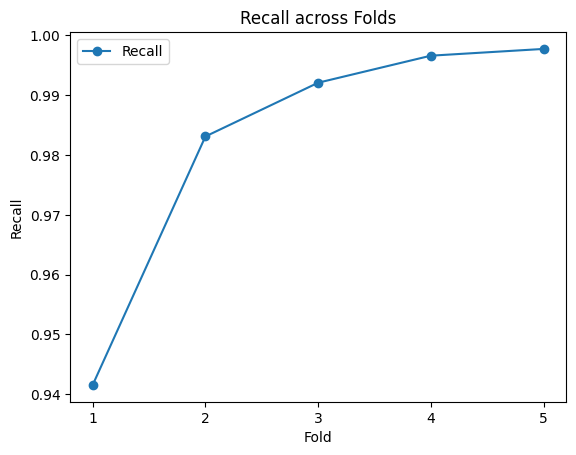

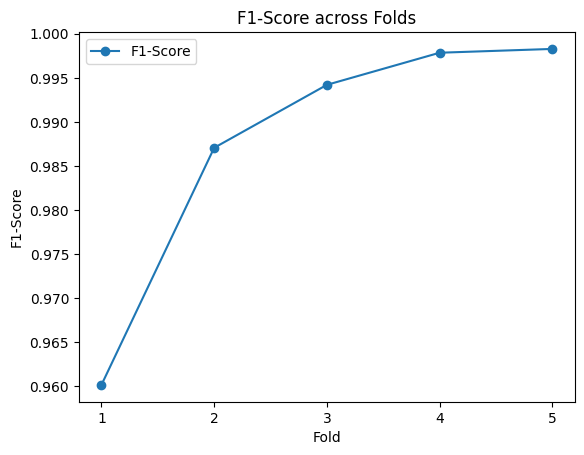

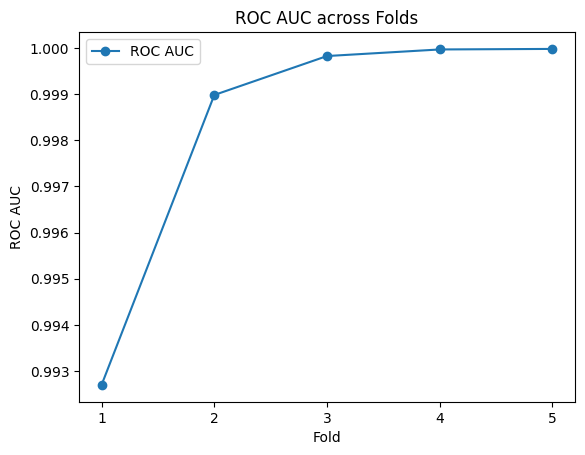

<Figure size 640x480 with 0 Axes>

In [20]:
training_accuracy_plt_filepath = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_accuracy_distilbert.png"
training_precision_plt_filepath = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_precision_distilbert.png"
training_recall_plt_filepath = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_recall_distilbert.png"
training_f1scores_plt_filepath = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_f1scores_distilbert.png"
training_rocauc_plt_filepath = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_rocauc_distilbert.png"

# Plot validation accuracy across folds
plot_scores_across_folds(accuracy_scores_list, "Accuracy", output_file=training_accuracy_plt_filepath)
# Plot precision across folds
plot_scores_across_folds(precision_scores_list, "Precision", output_file=training_precision_plt_filepath)
# Plot recall across folds
plot_scores_across_folds(recall_scores_list, "Recall", output_file=training_recall_plt_filepath)
# Plot F1-score across folds
plot_scores_across_folds(f1_scores_list, "F1-Score", output_file=training_f1scores_plt_filepath)
# Plot ROC AUC across folds
plot_scores_across_folds(roc_auc_values, "ROC AUC", output_file=training_rocauc_plt_filepath)

In [21]:
(avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc) = calc_avg_cv(accuracy_scores_list, precision_scores_list, recall_scores_list, f1_scores_list, roc_auc_values, N_FOLDS)

CSV_FILE_PATH = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/CV/cv_metric_results_distilbert.csv"
cv_eval = save_result_to_csv(avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc, CSV_FILE_PATH)

print(f"CV Accuracy Score: {avg_accuracy}")
print(f"CV Precision Score: {avg_precision}")
print(f"CV Recall Score: {avg_recall}")
print(f"CV F1 Score: {avg_f1}")
print(f"CV ROC AUC: {avg_roc}")

CV Accuracy Score: 0.9876656160528539
CV Precision Score: 0.9929561482425877
CV Recall Score: 0.9822193277324992
CV F1 Score: 0.9875082907035008
CV ROC AUC: 0.9982936147005986


In [22]:
output_model_file = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Model/distilbert"
output_vocab_file = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Model/distilbertvocab.txt"

model.save_pretrained(output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

('/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Model/distilbertvocab.txt',)

In [23]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(output_model_file)
loaded_tokenizer = DistilBertTokenizer.from_pretrained(output_vocab_file)

accuracy_holdout, precision_holdout, recall_holdout, f1_holdout, roc_auc_holdout = holdout_performance_measure(loaded_model, loaded_tokenizer, holdout_data)

CSV_FILE_PATH = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Holdout/holdout_metric_results_distilbert.csv"
holdout_eval = save_result_to_csv(accuracy_holdout, precision_holdout, recall_holdout, f1_holdout, roc_auc_holdout, CSV_FILE_PATH)

print("Holdout Accuracy:", accuracy_holdout)
print("Holdout Precision:", precision_holdout)
print("Holdout Recall:", recall_holdout)
print("Holdout F1-score:", f1_holdout)
print("Holdout ROC-AUC:", roc_auc_holdout)

Some layers from the model checkpoint at /content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Model/distilbert were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Model/distilbert and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to us

1451/1451 [==============================] - 46s 29ms/step
Holdout Accuracy: 0.9635678121296994
Holdout Precision: 0.9706256860592756
Holdout Recall: 0.9558111380145279
Holdout F1-score: 0.9631614491427577
Holdout ROC-AUC: 0.9912880094396666
